In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import scipy.ndimage
from PIL import Image as PILImage

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

import input_data

In [13]:

# Read MNIST data
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [41]:
print(x_train[0])

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

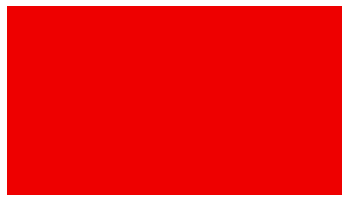

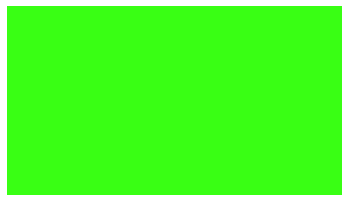

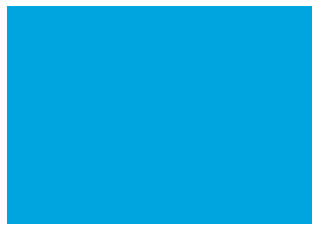

In [25]:


# Read BG image
blue = PILImage.open('backgrounds/blue.jpg')
red = PILImage.open('backgrounds/red.jpg')
green = PILImage.open('backgrounds/green.jpg')


plt.imshow(red)
plt.axis('off')
plt.show()

plt.imshow(green)
plt.axis('off')
plt.show()

plt.imshow(blue)
plt.axis('off')
plt.show()

In [36]:
def get_mnist_batch(bg, batch_size=256, change_colors=False):
    
    # Select random batch (WxHxC)
    idx = np.random.choice(x_train.shape[0], batch_size)
    print(idx)
    batch_raw = x_train[idx, :, :, 0].reshape((batch_size, 28, 28, 1))
    
    # Resize
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (2.3, 2.3, 1), order=1) for image in batch_raw])
    
    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)
    
    # Make binary
    batch_binary = (batch_rgb > 0.5)
    
    batch = np.zeros((batch_size, 64, 64, 3))
    
    for i in range(batch_size):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, bg.size[0] - 64)
        y_c = np.random.randint(0, bg.size[1] - 64)
        image = bg.crop((x_c, y_c, x_c + 64, y_c + 64))
        image = np.asarray(image) / 255.0

        if change_colors:
            # Change color distribution
            for j in range(3):
                image[:, :, j] = (image[:, :, j] + np.random.uniform(0, 1)) / 2.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]
        
        batch[i] = image
    
    # Map the whole batch to [-1, 1]
    #batch = batch / 0.5 - 1

    return batch

In [37]:
get_mnist_batch(green, 5)

[50187 12150 31902 34750 54068]


array([[[[0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         ...,
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137]],

        [[0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         ...,
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137]],

        [[0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         ...,
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137]],

        ...,

        [[0.22352941, 1.        , 0.07843137],
         [0.22352941, 1.        , 0.07843137]

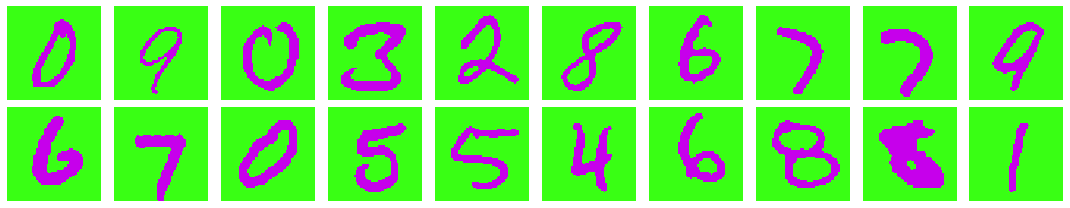

In [28]:
count = 20
examples = get_mnist_batch(green, count)

# Map back to normal range
#examples = (examples + 1) * 0.5

plt.figure(figsize=(15,3))
for i in range(count):
    plt.subplot(2, count // 2, i+1)
    plt.imshow(examples[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

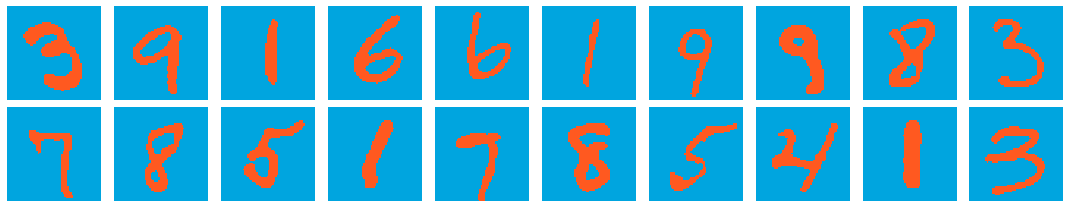

In [29]:
count = 20
examples = get_mnist_batch(blue, count)

# Map back to normal range
#examples = (examples + 1) * 0.5

plt.figure(figsize=(15,3))
for i in range(count):
    plt.subplot(2, count // 2, i+1)
    plt.imshow(examples[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

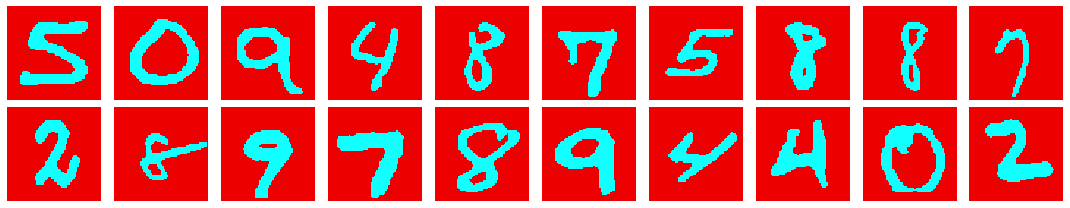

In [35]:
count = 20
examples = get_mnist_batch(red, count)

# Map back to normal range
#examples = (examples + 1) * 0.5

plt.figure(figsize=(15,3))
for i in range(count):
    plt.subplot(2, count // 2, i+1)
    plt.imshow(examples[i])
    plt.axis('off')
    plt.savefig("red.png")
plt.tight_layout()
plt.show()

In [33]:
plot(range(80))
xlabel('foo')
ylabel('bar')
legend(['myline'])
axis([0, 80, 0, 120])
savefig('sample.png')

NameError: name 'plot' is not defined

In [32]:
cd mnist/Output/training/1

/home/poorvi/Desktop/cs485_rnd_nutan_ma'am/Feb7/mnist/Output/training/1
